# Implementing P2P algorithms

In the previous notebooks we learned how to build custom components, send tasks and data and make clients communicate to each other. With that knowledge now available, in this notebook, we'll explore how to build and run custom P2P algorithms. As a guiding example, we will try to re-implement from scratch the basics of the `nvflare.app_opt.p2p` module, which implements peer-to-peer (P2P) distributed optimization algorithms.

To do that we need a few things:

- A flexible way to define the communication topology of the clients along with some othe configuration parameters. In the previous example we hardcoded the list of clients to which each client should send data. In this notebook we'll use a more flexible approach, where the communication topology is defined by a graph.
- A controller that can share the communication topology with the clients and then assign them the task to run the P2P algorithm.
- A client that can receive the communication topology and run the P2P algorithm. Since we plan to implement synchronous P2P algorithms, we'll also need a way to synchronize all the clients with each other.

## Communication topology configuration

We'll start by simply defining a `Node` (i.e. a client in the network), its `Neighbors` (i.e. other clients with which a client communicates, each with a weight) and combine them to define a `Network` (i.e. a network of clients with neighbors).

```python
from dataclasses import dataclass, field

@dataclass
class Neighbor:
    id: int | str
    weight: float | None = None

@dataclass
class Node:
    id: int | str
    neighbors: list[Neighbor] = field(default_factory=list)

@dataclass
class Network:
    nodes: list[Node] = field(default_factory=list)
```

Then we'll define a global and a local config objects to be passed to the controller and executors respectively.

```python
@dataclass
class Config:
    network: Network
    extra: dict = field(default_factory=dict)

@dataclass
class LocalConfig:
    neighbors: list[Neighbor]
    extra: dict = field(default_factory=dict)
```

The `extra` parameter can be used to pass additional parameters, usually specific for the various algorithms. 

To actual implementation of the objects above can be found in `nvflare/app_opt/p2p/types/__init__.py` (you'll see they'll have the `__dict__` and `__post_init__` methods defined facilitate serializing and deserializing them, which is needed for NVFlare). You also have some utils to generate random configs for experimentation.

In [4]:
from nvflare.app_opt.p2p.utils.config_generator import generate_random_network
from rich import print

network, adjacency_matrix = generate_random_network(num_clients=3)
print(network)
print(adjacency_matrix)

Network(
    nodes=[
        Node(id='site-1', neighbors=[Neighbor(id='site-2', weight=0.3333333432674408)]),
        Node(
            id='site-2',
            neighbors=[
                Neighbor(id='site-1', weight=0.3333333432674408),
                Neighbor(id='site-3', weight=0.3333333432674408)
            ]
        ),
        Node(id='site-3', neighbors=[Neighbor(id='site-2', weight=0.3333333432674408)])
    ]
)

tensor([[0.6667, 0.3333, 0.0000],
        [0.3333, 0.3333, 0.3333],
        [0.0000, 0.3333, 0.6667]])

In [5]:
from nvflare.app_opt.p2p.types import Config
config = Config(network=network, extra={"iterations": 100})
print(config)

Config(
    network=Network(
        nodes=[
            Node(id='site-1', neighbors=[Neighbor(id='site-2', weight=0.3333333432674408)]),
            Node(
                id='site-2',
                neighbors=[
                    Neighbor(id='site-1', weight=0.3333333432674408),
                    Neighbor(id='site-3', weight=0.3333333432674408)
                ]
            ),
            Node(id='site-3', neighbors=[Neighbor(id='site-2', weight=0.3333333432674408)])
        ]
    ),
    extra={'iterations': 100}
)

### Exercise
Create a ring network with 3 clients and add it to a config, along with the number of iterations. Your config should look like this:
```shell
Config(
    extra={"iterations":100},
    network=Network(
        nodes=[
            Node(
                id='site-1',
                neighbors=[
                    Neighbor(id='site-2', weight=0.1),
                ]
            ),
            Node(
                id='site-2',
                neighbors=[
                    Neighbor(id='site-3', weight=0.1),
                ]
            ),
            Node(
                id='site-3',
                neighbors=[
                    Neighbor(id='site-1', weight=0.1),
                ]
            ),
        ]
    )
)
```

## The controller

Let's now look at how to implement our controller with the specifications above. The configuration can be passed to the controller when initializing it, while the `control_flow` method will be responsible for sending the configuration to the clients and then running the algorithm.

### Initializing the Controller
To initialize the controller to, we override the `__init__` method to accept a `Config` object, which contains the network configuration and any extra parameters needed for the algorithm

```python
from nvflare.app_opt.p2p.types import Config

class DistOptController(Controller):
    def __init__(self, config: Config, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.config = config
```

> NOTE: the name of the init arguments and the class parameters need to match for the object to be instantiatable by NVFlare (see [here](https://nvflare.readthedocs.io/en/main/programming_guide/fed_job_api.html)).

### Implementing the Control Flow

In the control_flow method, we'll perform two main steps:

1. Send the network configuration to the clients: Each client receives its specific configuration, such as neighbor information.

2. Run the algorithm: Instruct all clients to start executing the P2P optimization algorithm.

Let's first look at the implementation and then we'll break it down.


```python
from nvflare.apis.controller_spec import Task
from nvflare.apis.dxo import DXO, DataKind

class DistOptController(Controller):

    ...

    def control_flow(self, abort_signal: Signal, fl_ctx: FLContext):
        # 1. Send network config to each client
        for node in self.config.network.nodes:
            # Prepare the data using DXO
            data = DXO(
                data_kind=DataKind.APP_DEFINED,
                data={"neighbors": [n.__dict__ for n in node.neighbors]},
            ).to_shareable()

            # Create the task with name "config"
            task = Task(name="config", data=data)

            # Send the task to the specific client and wait for completion
            self.send_and_wait(task=task, targets=[node.id], fl_ctx=fl_ctx)

        # 2. Instruct clients to run the algorithm
        targets = [node.id for node in self.config.network.nodes]
        
        # Prepare any extra parameters to send to the clients
        data = DXO(
            data_kind=DataKind.APP_DEFINED,
            data={key: value for key, value in self.config.extra.items()},
        ).to_shareable()

        # Create the task with name "run_algorithm"
        task = Task(name="run_algorithm", data=data)

        # Broadcast the task to all clients and wait for all to respond
        self.broadcast_and_wait(
            task=task,
            targets=targets,
            min_responses=0,
            fl_ctx=fl_ctx,
        )
```

#### Implementation break-down
1. Send the network configuration to the clients
    - For each node in the network configuration:
        - Prepare the data using DXO:
            - We create a `DXO` object with the neighbors' information. As discussed, it encapsulates the data to be sent to the client. Here, we use `DataKind.APP_DEFINED` to indicate that the data is application-defined.
        - Convert the `DXO` to a `Shareable`:
            - We call `.to_shareable()` to create a `Shareable` object from the `DXO`. This conversion is necessary because NVFlare's communication mechanism uses `Shareable` objects. As mentioned, the `Shareable` object wraps the data to be transferred between server and clients. 
        - Create a task with name `"config"`:
            - We create a `Task` named `"config"` with the `Shareable` data. The task name "config" identifies the task type, which the client will recognize and handle accordingly (we'll see that in the next section, when building the executors)/
        - Send the task to the specific client and wait for completion:
            - Here we use the `send_and_wait` method to send the task to the target client (`node.id`) and wait for it to complete the task. This ensures synchronization before moving to the next step.
2. Running the Algorithm
    - Prepare the list of target clients:
        - We collect all node IDs from the network configuration into the `targets` list.
    - Prepare any extra parameters:
        - We create a `DXO` with any extra parameters needed for the algorithm, stored in `self.config.extra`.
    - Create and broadcast the task:
        - We create a `Task` named `"run_algorithm"` with the `Shareable` data.
        - Broadcast and wait:
            - We use `broadcast_and_wait` to send the task to all target clients. As the name suggests, this method broadcasts the same task to all specified clients and waits for their responses. Here, we set `min_responses=0`, indicating that we wait for all clients to respond/complete the algorithm before proceeding.

## The executor

As said, for our purposes, we'll need our executor to be able to do a few things:
- Receive the configuration from the server/controller.
- Communicate with its neighbors and send/receive messages to/from them.
- Run the algorithm in a synchronous way.

As we've learned in the previous sections, the primary method we need to implement is the `execute` method, which processes tasks received from the controller. We'll make it handle 2 different tasks: `config` and `run_algorithm`.

### Basic Structure
Here's the basic structure of our executor:

```python
from nvflare.apis.executor import Executor
from nvflare.apis.fl_constant import ReturnCode
from nvflare.apis.fl_context import FLContext
from nvflare.apis.shareable import Shareable, make_reply
from nvflare.apis.signal import Signal


class SyncAlgorithmExecutor(Executor):

    def execute(
        self,
        task_name: str,
        shareable: Shareable,
        fl_ctx: FLContext,
        abort_signal: Signal,
    ):
        if task_name == "config":
            # TODO: receive and store config
            ...
            return make_reply(ReturnCode.OK)
        elif task_name == "run_algorithm":
            # TODO: run the algorithm
            return make_reply(ReturnCode.OK)
        else:
            self.log_warning(fl_ctx, f"Unknown task name: {task_name}")
            return make_reply(ReturnCode.TASK_UNKNOWN)
```

### Handling the `"config"` task

Let's focus on handling the `"config"` task first. We need to receive configuration data from the server and store it locally. We'll also initialize attributes to store the configuration and the neighbors' information.

```python
from nvflare.apis.dxo import from_shareable
from nvflare.app_opt.p2p.types import LocalConfig, Neighbor


class SyncAlgorithmExecutor(Executor):
    def __init__(self):
        super().__init__()

        self.config = None
        self._weight = None
        self.neighbors: list[Neighbor] = []


    def execute(
        self,
        task_name: str,
        shareable: Shareable,
        fl_ctx: FLContext,
        abort_signal: Signal,
    ):
        if task_name == "config":
            # Receive and store config
            self.config = LocalConfig(**from_shareable(shareable).data)
            self.neighbors = self.config.neighbors

            # Compute local weight
            self._weight = 1.0 - sum([n.weight for n in self.neighbors])

            return make_reply(ReturnCode.OK)

        elif task_name == "run_algorithm":
            # TODO: run the algorithm
            return make_reply(ReturnCode.OK)
        else:
            self.log_warning(fl_ctx, f"Unknown task name: {task_name}")
            return make_reply(ReturnCode.TASK_UNKNOWN)
```

Here, we're using the `LocalConfig` we defined above to store the client's local configuration, including neighbors in a pythonic way.

> EXERCISE: try to create a job with the controller and executor we built so far and explore the config of each client.

### P2P communication and synchronization

We know from the previous notebook how to perform P2P communication via the `send_aux_request` and registering a handler to take care of the received message through the aux channel.

Now, we'll need two more things for our purposes:
- Synchronizing execution: Using threading events and locks to coordinate the execution of the algorithm.
- Handling message formats: Implementing methods to serialize and deserialize messages (this is useful, for example, to send torch tensors). We'll add two methods, `_from_message` and `_to_message` to do that.

The main message exchange will be done in the `_exchange_values` function. Let's first look at the implementation and then we'll discuss it in detail.

```python
import threading
from abc import abstractmethod
from collections import defaultdict

from nvflare.apis.dxo import DXO, DataKind
from nvflare.apis.event_type import EventType
from nvflare.apis.signal import Signal


class SyncAlgorithmExecutor(Executor):
    def __init__(self, sync_timeout: int = 10):
        super().__init__()
        ... # other attributes

        self.neighbors_values = defaultdict(dict)

        # Threading primitives for synchronization
        self.sync_waiter = threading.Event()
        self.lock = threading.Lock()
        self.sync_timeout = sync_timeout


    def _exchange_values(self, fl_ctx: FLContext, value: any, iteration: int):
        engine = fl_ctx.get_engine()

        # Clear the event before starting the exchange
        self.sync_waiter.clear()

        # Send message to neighbors
        targets = [neighbor.id for neighbor in self.neighbors]
        data = DXO(
            data_kind=DataKind.METRICS,
            data={
                "value": self._to_message(value),
                "iteration": iteration,
            },
        ).to_shareable()

        # Send auxiliary request to neighbors
        _ = engine.send_aux_request(
            targets=targets,
            topic="send_value",
            request=data,
            timeout=10,
            fl_ctx=fl_ctx,
        )

        # check if all neighbors sent their values
        if len(self.neighbors_values[iteration]) < len(self.neighbors):
            # if not, wait for them (up to self.sync_timeout seconds, defaults to 10)
            if not self.sync_waiter.wait(timeout=self.sync_timeout):
                self.system_panic("failed to receive values from all neighbors", fl_ctx)
                return

    def _handle_neighbor_value(
        self, topic: str, request: Shareable, fl_ctx: FLContext
    ) -> Shareable:
        # Retrieve the sender's identity from the request
        sender = request.get_peer_props()["__identity_name__"]
        data = from_shareable(request).data
        iteration = data["iteration"]

        with self.lock:
            # Store the received value
            self.neighbors_values[iteration][sender] = self._from_message(data["value"])
            # Check if all neighbor values have been received
            if len(self.neighbors_values[iteration]) >= len(self.neighbors):
                self.sync_waiter.set()  # Signal that we have all neighbor values
        return make_reply(ReturnCode.OK)

    def handle_event(self, event_type: str, fl_ctx: FLContext):
        if event_type == EventType.START_RUN:
            engine = fl_ctx.get_engine()
            # Register the message handler for receiving neighbor values
            engine.register_aux_message_handler(
                topic="send_value", message_handle_func=self._handle_neighbor_value
            )

    def _to_message(self, x):
        # Method to serialize the value for transmission
        return x

    def _from_message(self, x):
        # Method to deserialize the received value
        return x

```

While this may look complex, it's actually quite straightforward with the knowledge we built up in previous sections.

Let's break down the key components of this implementation:
- Additional parameters:
    - `sync_waiter` (threading.Event): An event that allows threads to wait until it is set. Used here to synchronize the execution of the algorithm, making clients wait until all neighbor values have been received.
    - `lock` (threading.Lock): Ensures thread-safe access to shared data structures, such as neighbors_values.
    - `neighbors_values`: A dictionary that stores received values from neighbors, organized by iteration.
- `_exchange_values`: a custom method to handle the exchange of values with neighbors during each iteration. It follows the following process:
    1. Clears the `sync_waiter` event to ensure we're starting fresh.
    2. Sends an auxiliary request to each neighbor with the current value and iteration number.
    3. Checks if all neighbor values have been received; if not, waits for `sync_waiter` to be set or times out after 10 seconds.
    4. Handling Timeout: If the required neighbor values are not received within the timeout, the method calls `system_panic` to handle the error (usually logging and cleanup).
- `_handle_neighbor_value`: a custom callback to handle incoming messages from neighbors containing their values. It works by:
    1. Extracting the sender's identity and the data from the request.
    2. Storing the received value in `neighbors_values` under the appropriate iteration.
    3. Checking if all neighbor values for the iteration have been received; if so, sets `sync_waiter` to release any waiting threads.
    4. Thread Safety: Uses a `lock` to ensure that the update to `neighbors_values` and the check is atomic.
- `handle_event`: implement the `handle_event` of the base `Executor` to handle events sent by the engine. In this case. when `EventType.START_RUN` (i.e. when the run )starts, we register the auxiliary message handler for receiving neighbor values.
- `_to_message` and `_from_message`: custom placeholder methods for serializing and deserializing the message content. In subclasses, you might need to override these methods to handle complex data structures or use specific serialization formats (e.g., converting tensors to and from bytes).


> Notice that `neighbors_values` needs to maintain a dictionary of received values per iteration. This is because, different parts of a network may be at different iterations of the algorithm (plus or minus 1 at most) - this means that I could receive a message from a neighbor valid for iteration `t+1` when I'm still at iteration `t`. Since that message won't be sent again, I need to store it. **To avoid the `neighbors_values` to grow indefinitely, we'll delete its content at iteration `t` after having consumed its values and moving to the next iteration in the algorithm**. This can be done by `del self.neighbors_values[iteration]` after we're done with an iteration.

### Creating and running a custom P2P algorithm

Now that we have a way to store the configuration and exchange messages with neighbors, we can implement the algorithmic part. For this `SyncAlgorithmExecutor`, we'll define an abstract `run_algorithm` method to be overridden by subclasses implementing specific algorithms.

```python
from abc import ABC, abstractmethod

class SyncAlgorithmExecutor(Executor, ABC):
    ...

    @abstractmethod
    def run_algorithm(
        self, fl_ctx: FLContext, shareable: Shareable, abort_signal: Signal
    ):
        """Executes the algorithm. Must be overridden by subclasses."""
        pass

    def execute(
        self,
        task_name: str,
        shareable: Shareable,
        fl_ctx: FLContext,
        abort_signal: Signal,
    ):
        if task_name == "config":
            # Receive topology from the server
            self.config = LocalConfig(**from_shareable(shareable).data)
            self.neighbors = self.config.neighbors
            self._weight = 1.0 - sum([n.weight for n in self.neighbors])
            return make_reply(ReturnCode.OK)

        elif task_name == "run_algorithm":
            # Run the algorithm
            if abort_signal.triggered:
                return make_reply(ReturnCode.TASK_ABORTED)

            self.run_algorithm(fl_ctx, shareable, abort_signal)
            return make_reply(ReturnCode.OK)

        else:
            self.log_warning(fl_ctx, f"Unknown task name: {task_name}")
            return make_reply(ReturnCode.TASK_UNKNOWN)
```

The full implementation is in `nvflare/app_opt/p2p/executors/sync_executor.py` - note that the implementation of the `SyncAlgorithmExecutor` in `nvflare.app_opt.p2p` is a subclass of `BaseDistOptExecutor`, defined in `nvflare/app_opt/p2p/executors/base_dist_opt_executor.py`. It contains a few additional attributes (namely `self.id` and `self.client_name`) to identify the client, which are potentially useful in algorithms, and two additional methods `_pre_algorithm_run` and `_post_algorithm_run` to be overridden by each specific algorithm to execute some code before and after the algorithm execution, respectively.

#### Example: Implementing the `ConsensusExecutor`

Now that we have built the main foundation with `SyncAlgorithmExecutor`, we can implement specific algorithms by subclassing it. Let's implement the consensus algorithm in the `ConsensusExecutor`.

##### Consensus Algorithm Overview
The consensus algorithm allows clients to reach agreement on a certain value through iterative averaging with their neighbors. Each client updates its value based on its own value and the values received from its neighbors, weighted accordingly. In formulas, each client $i$ maintains some local value $x_i^t$ and is connected to a subset of the other clients in the network, defined as the set of its neighbors $\mathcal{N}_i$.
The goal of all the clients is to reach consensus on their local values by communicating with their peers for a certain number of iterations $T$. 
In other terms, they want to cooperatively compute a weighted average of their initial values $x_i^0$.

The consensus algorithm works by having each client updating its local value as

$$x_i^{t+1} = \sum_{j\in\mathcal{N}_i}a_{ji}x_j^t$$

where $a_{ji}$ is the weight associated by client $i$ to client $j$ and $\sum_{j=1}^N a_{ji}=1$ for all $i$.

#### Implemntation

```python
import torch

class ConsensusExecutor(SyncAlgorithmExecutor):

    def __init__(
        self,
        initial_value: float | None = None,
    ):
        super().__init__()
        if initial_value is None:
            initial_value = random.random()
        self.initial_value = initial_value
        self.current_value = initial_value
        self.value_history = [self.current_value]

    def run_algorithm(self, fl_ctx, shareable, abort_signal):
        iterations = from_shareable(shareable).data["iterations"]

        for iteration in range(iterations):
            if abort_signal.triggered:
                self.log_info(fl_ctx, "Abort signal received. Exiting the algorithm loop.")
                break

            # 1. Exchange values with neighbors
            self._exchange_values(
                fl_ctx, value=self.current_value, iteration=iteration
            )

            # 2. Compute new value
            current_value = self.current_value * self._weight
            for neighbor in self.neighbors:
                neighbor_value = self.neighbors_values[iteration][neighbor.id]
                current_value += neighbor_value * neighbor.weight

            # 3. Store current value and history
            self.current_value = current_value
            self.value_history.append(self.current_value)

            # 4. Free memory that's no longer needed
            del self.neighbors_values[iteration]
        
        # save value_history
        torch.save(torch.tensor(self.value_history), "value_sequence.pt")

```

Let's explain the key parts:

- Initialization:
    - Sets an initial random value if none is provided.
    - Initializes `current_value` and `value_history` to keep track of the values over iterations.
- `run_algorithm`:
    - Retrieves the number of iterations from the shareable received.
    - For each iteration:
        1. Abort check: Checks if an abort signal has been triggered.
        2. Exchange values: Calls `_exchange_values` to send and receive values with neighbors.
        3. Compute new value by computing the weighted average of the current value and the received values from neighbors.
        4. Update state (`current_value`) and store value in `value_history`
        5. Cleanup: Deletes the neighbor values for the iteration to free up memory.
    - We let each client save their `value_history` to disk at the end of the algorithm

We can now run our algorithm

In [6]:
from nvflare.job_config.api import FedJob
from nvflare.app_opt.p2p.executors import ConsensusExecutor
from nvflare.app_opt.p2p.controllers import DistOptController

job = FedJob(name="consensus")

controller = DistOptController(config=config)
job.to_server(controller)

for i in range(3):
    executor = ConsensusExecutor()
    job.to(executor, f"site-{i+1}")

# Run job via the NVFlare simulator
job.export_job("./tmp/job_configs")
job.simulator_run("./tmp/runs/consensus")

2025-02-07 11:27:51,456 - SimulatorRunner - INFO - Create the Simulator Server.
2025-02-07 11:27:51,458 - CoreCell - INFO - server: creating listener on tcp://0:54189
2025-02-07 11:27:51,744 - CoreCell - INFO - server: created backbone external listener for tcp://0:54189
2025-02-07 11:27:51,745 - ConnectorManager - INFO - 7328: Try start_listener Listener resources: {'secure': False, 'host': 'localhost', <DriverParams.CONNECTION_SECURITY: 'connection_security'>: 'clear'}
2025-02-07 11:27:51,746 - conn_manager - INFO - Connector [CH00002 PASSIVE tcp://0:12975] is starting
2025-02-07 11:27:52,247 - CoreCell - INFO - server: created backbone internal listener for tcp://localhost:12975
2025-02-07 11:27:52,248 - conn_manager - INFO - Connector [CH00001 PASSIVE tcp://0:54189] is starting
2025-02-07 11:27:52,251 - AuxRunner - INFO - registered aux handler for topic ObjectStreamer.Request
2025-02-07 11:27:52,252 - AuxRunner - INFO - registered aux handler for topic ObjectStreamer.Abort
2025-02

Let's inspect the saved values to see if the algorithm is working and the clients are reaching a consensus

/var/folders/82/970ljrw529v0chx2svm8gwwr0000gp/T/ipykernel_6723/195547863.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  f"site-{i+1}": torch.load(f"tmp/runs/consensus/

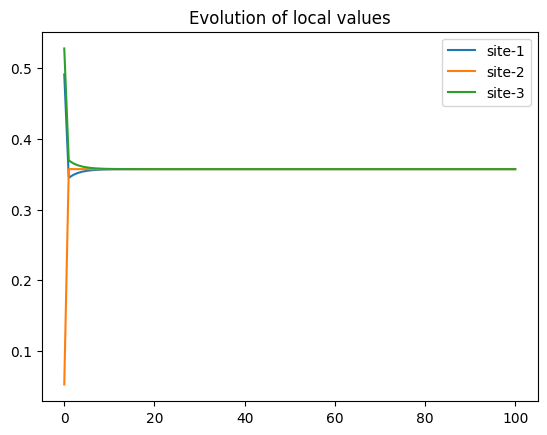

In [7]:
#!pip install matplotlib torch
import torch
import matplotlib.pyplot as plt

# load history
history = {
    f"site-{i+1}": torch.load(f"tmp/runs/consensus/site-{i+1}/value_sequence.pt") for i in range(3)
}

# plot results
plt.figure()
for i in range(3):
    plt.plot(history[f"site-{i+1}"], label=f"site-{i+1}")
plt.legend()
plt.title("Evolution of local values")
plt.show()

## Exercises

1. Try to implement another P2P algorithms of your choice - for example the distributed gradient descent. 
2. What happens if you remove the synchronization?